# Airbnb
### Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
sns.set_style('darkgrid')
%matplotlib inline

### Q1. Does Airbnb have seasonality to their availability?

In [4]:
df = pd.read_csv('airbnb_calendar.csv')
df['date'] = pd.to_datetime(df['date'])
df.info(), df['date'].min(),df['date'].max()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2702460 entries, 0 to 2702459
Data columns (total 5 columns):
Unnamed: 0    int64
listing_id    int64
date          datetime64[ns]
City          object
Occupied      int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 103.1+ MB


(None, Timestamp('2016-01-04 00:00:00'), Timestamp('2017-09-05 00:00:00'))

C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


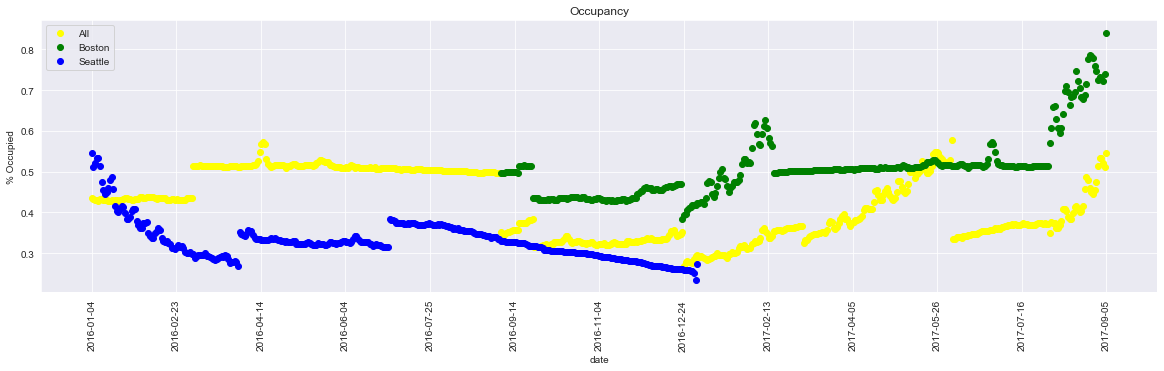

In [22]:
d0 = df['date'].min()
d1 = df['date'].max()
delta = (d1 - d0) / 12
plt.figure(figsize=(20,5))
plt.plot_date(df['date'].unique(), df.groupby(['date']).mean()['Occupied'], color='yellow', label='All')
plt.plot_date(df[df['City']=='Boston']['date'].unique(), df[df['City']=='Boston'].groupby(['date']).mean()['Occupied'], color='green', label='Boston')
plt.plot_date(df[df['City']=='Seattle']['date'].unique(), df[df['City']=='Seattle'].groupby(['date']).mean()['Occupied'], color='blue', label='Seattle')
plt.title('Occupancy')
plt.ylabel('% Occupied')
plt.xlabel('date')
plt.xticks(np.arange(d0, d1 + delta, step=delta), rotation=90)

ax = plt.subplot(111)
ax.legend()

plt.show();

Although some seasonality appears to exist, we may want to categorize the listings a little for better insight

In [7]:
dfl = pd.read_csv('airbnb_listings.csv')

In [8]:
dfl.groupby(['property_type', 'room_type']).count()['id']

property_type    room_type      
Apartment        Entire home/apt    3192
                 Private room       1015
                 Shared room         113
Bed & Breakfast  Entire home/apt       5
                 Private room         71
                 Shared room           2
Boat             Entire home/apt      14
                 Private room          6
Bungalow         Entire home/apt      12
                 Private room          1
Cabin            Entire home/apt      16
                 Private room          5
Camper/RV        Entire home/apt      10
                 Private room          3
                 Shared room           1
Chalet           Entire home/apt       1
                 Private room          1
Condominium      Entire home/apt     222
                 Private room         97
                 Shared room           3
Dorm             Private room          2
                 Shared room           2
Entire Floor     Entire home/apt       2
                 Private

For the purposes of this investigation, we will focus on completely stationary rentals (no RVs, tents, etc)

In [9]:
dfs = dfl[dfl['property_type'].isin(['Apartment', 'Bed & Breakfast','Bungalow','Cabin','Chalet','Condominium','Dorm','Entire Floor','Guesthouse','House','Loft','Townhouse','Treehouse','Villa'])].copy()
dfs['beds'].fillna(1, inplace=True)
dfs['bathrooms'].fillna(1, inplace=True)
dfs['security_deposit'].fillna(0, inplace=True)
dfs['cleaning_fee'].fillna(0, inplace=True)
dfs.rename(columns={"id": "listing_id"}, inplace=True)
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7320 entries, 0 to 7402
Data columns (total 36 columns):
Unnamed: 0                          7320 non-null int64
listing_id                          7320 non-null int64
host_response_rate                  6342 non-null object
host_acceptance_rate                6097 non-null object
host_is_superhost                   7318 non-null object
host_listings_count                 7318 non-null float64
neighbourhood_cleansed              7320 non-null object
latitude                            7320 non-null float64
longitude                           7320 non-null float64
property_type                       7320 non-null object
room_type                           7320 non-null object
accommodates                        7320 non-null int64
bathrooms                           7320 non-null float64
beds                                7320 non-null float64
bed_type                            7320 non-null object
price                               

In [10]:
#Next steps: Inner join to calendar to run availability by room type and/or property type
dfj = dfs[['listing_id','property_type','room_type','accommodates','bathrooms','beds','bed_type','price', 'security_deposit', 'cleaning_fee']]
dfj = dfj.join(df.set_index('listing_id'), on='listing_id', lsuffix='_ids', rsuffix='_calendar')
dfj.head(), dfj.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2672165 entries, 0 to 7402
Data columns (total 14 columns):
listing_id          int64
property_type       object
room_type           object
accommodates        int64
bathrooms           float64
beds                float64
bed_type            object
price               float64
security_deposit    float64
cleaning_fee        float64
Unnamed: 0          int64
date                datetime64[ns]
City                object
Occupied            int64
dtypes: datetime64[ns](1), float64(5), int64(4), object(4)
memory usage: 305.8+ MB


(   listing_id property_type        room_type  accommodates  bathrooms  beds  \
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 0    12147973         House  Entire home/apt             4        1.5   3.0   
 
    bed_type  price  security_deposit  cleaning_fee  Unnamed: 0       date  \
 0  Real Bed  250.0               0.0          35.0           0 2017-09-05   
 0  Real Bed  250.0               0.0          35.0           1 2017-09-04   
 0  Real Bed  250.0               0.0          35.0           2 2017-09-03   
 0  Real Bed  250.0               0.0          35.0           3 2017-09-02   
 0  Real Bed  250.0               0.0          35.0           4 2017-09-01   
 
      City  Occupied  
 0  Boston         1  
 0

C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


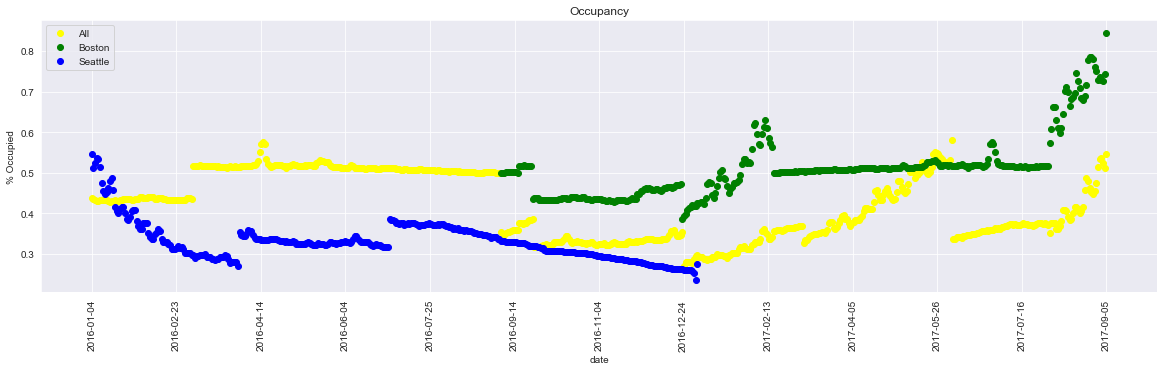

In [19]:
# Generate an availability graph using only stationary properties
d0 = dfj['date'].min()
d1 = dfj['date'].max()
delta = (d1 - d0) / 12
plt.figure(figsize=(20,5))
plt.plot_date(dfj['date'].unique(), dfj.groupby(['date']).mean()['Occupied'], color='yellow', label='All')
plt.plot_date(dfj[dfj['City']=='Boston']['date'].unique(), dfj[dfj['City']=='Boston'].groupby(['date']).mean()['Occupied'], color='green', label='Boston')
plt.plot_date(dfj[dfj['City']=='Seattle']['date'].unique(), dfj[dfj['City']=='Seattle'].groupby(['date']).mean()['Occupied'], color='blue', label='Seattle')
plt.title('Occupancy')
plt.ylabel('% Occupied')
plt.xlabel('date')
plt.xticks(np.arange(d0, d1 + delta, step=delta), rotation=90)

ax = plt.subplot(111)
ax.legend()

plt.show();

Removing the mobile type rentals didn't drastically alter our availability graph, which does show some seasonality. <br>
Overall, there is a busy season ramping up from early february until september, with small periods inbetween of fluxuating availability

### Does rental property type influence private room pricing?

In [12]:
dfp = dfs[dfs['room_type']=='Private room'].groupby(['property_type']).mean()['price'].copy()
dfp.nlargest(13)

property_type
Villa              152.500000
Bed & Breakfast    123.971831
Condominium        105.134021
Loft               100.647059
Apartment           94.184236
Entire Floor        90.000000
Townhouse           86.735294
House               74.551724
Cabin               74.400000
Bungalow            70.000000
Dorm                62.500000
Chalet              62.000000
Treehouse           51.500000
Name: price, dtype: float64

Despite it still only being a private room rental, there is a significant difference between rooms

### Does having a cleaning fee or security deposit increase your availability?

C:\Users\cwalk834\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


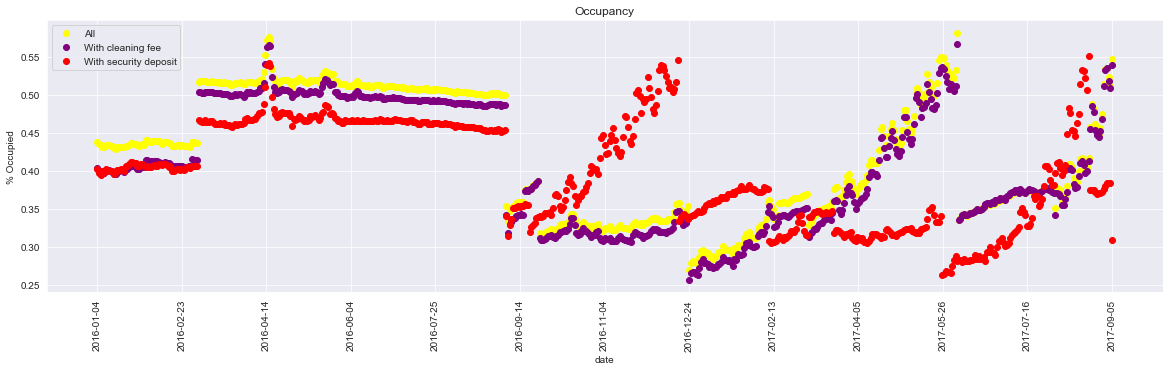

In [18]:
# Generate an availability graph using only stationary properties
d0 = dfj['date'].min()
d1 = dfj['date'].max()
delta = (d1 - d0) / 12
plt.figure(figsize=(20,5))
plt.plot_date(dfj['date'].unique(), dfj.groupby(['date']).mean()['Occupied'], color='yellow', label='All')
plt.plot_date(dfj[dfj['cleaning_fee']!=0]['date'].unique(), dfj[dfj['cleaning_fee']!=0].groupby(['date']).mean()['Occupied'], color='purple', label='With cleaning fee')
plt.plot_date(dfj[dfj['security_deposit']!=0]['date'].unique(), dfj[dfj['security_deposit']!=0].groupby(['date']).mean()['Occupied'], color='red', label='With security deposit')
plt.title('Occupancy')
plt.ylabel('% Occupied')
plt.xlabel('date')
plt.xticks(np.arange(d0, d1 + delta, step=delta), rotation=90)

ax = plt.subplot(111)
ax.legend()

plt.show();

There is some odd High availability season trending where a security deposit is correlated with a greater occupancy rate, lets take a look at the room type distribution concerning security deposits

In [14]:
dfs['has_security_deposit'] = np.where(dfs['security_deposit']>0, 1, 0)

In [15]:
dfs.groupby(['property_type', 'room_type']).mean()['has_security_deposit']

property_type    room_type      
Apartment        Entire home/apt    0.448935
                 Private room       0.291626
                 Shared room        0.194690
Bed & Breakfast  Entire home/apt    0.600000
                 Private room       0.154930
                 Shared room        0.000000
Bungalow         Entire home/apt    0.416667
                 Private room       0.000000
Cabin            Entire home/apt    0.375000
                 Private room       0.800000
Chalet           Entire home/apt    0.000000
                 Private room       0.000000
Condominium      Entire home/apt    0.603604
                 Private room       0.443299
                 Shared room        0.666667
Dorm             Private room       0.000000
                 Shared room        0.000000
Entire Floor     Entire home/apt    0.000000
                 Private room       0.000000
Guesthouse       Entire home/apt    1.000000
House            Entire home/apt    0.649712
                 Priva